<a href="https://colab.research.google.com/github/HeytorAlves/CartorioEbac/blob/main/C%C3%B3pia_de_colab_webcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab: Access Webcam for Images and Video
This notebook will go through how to access and run code on images and video taken using your webcam.  

For this purpose of this tutorial we will be using OpenCV's Haar Cascade to do face detection on our Webcam image and video.

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

## Helper Functions
Below are a few helper function to make converting between different image data types and formats.

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Haar Cascade Classifier
For this tutorial we will run a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam. OpenCV has a pre-trained Haar Cascade face detection model.

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

## Webcam Images
Running code on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** to utilize your computer's webcam.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


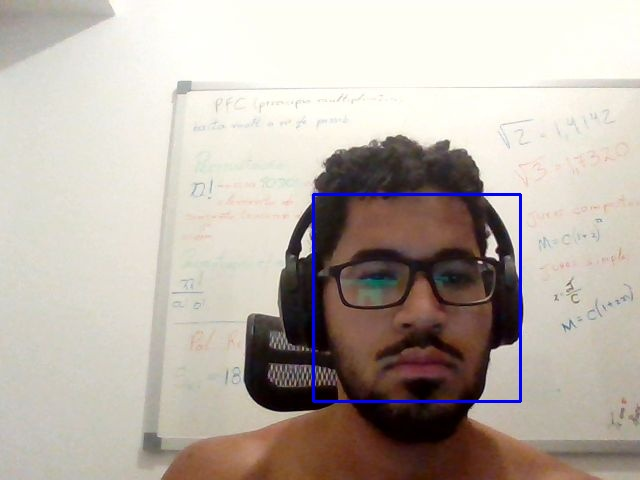

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Webcam Videos
Running code on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our progam (face detection) and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

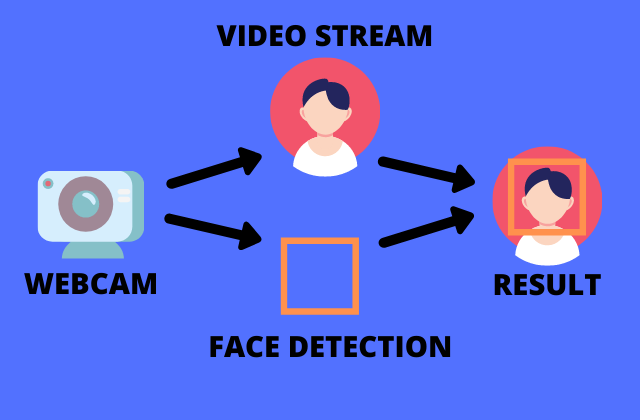</center>

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

/tmp/ipython-input-480462610.py:27: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')


Diretórios configurados com sucesso!
Classe H: /content/h
Classe B: /content/b
Faces extraídas: /content/faces_dataset

=== VERIFICANDO IMAGENS DA CLASSE H ===
Encontradas 12 imagens em /content/h
  - h (19).jpg
  - h (17).JPG
  - h (18).JPG
  - h (22).jpg
  - h (21).jpg
  - h (16).jpg
  - h (14).jpg
  - h (15).jpg
  - h (6).jpg
  - h (1).jpg
  - h (23).jpg
  - h (20).jpg

=== VERIFICANDO IMAGENS DA CLASSE B ===
Encontradas 12 imagens em /content/b
  - b (4).jpg
  - b (3).jpg
  - b (2).jpg
  - b (1).jpg
  - b (8).jpg
  - b (5).jpg
  - b (7).jpg
  - b (11).jpg
  - b (9).jpg
  - b (6).jpg
  - b (10).jpg
  - b (12).jpg

INICIANDO EXTRAÇÃO DE ROSTOS

=== EXTRAINDO ROSTOS DA CLASSE H ===
✓ Rosto 1 extraído de h (19).jpg -> H_h (19)_0.jpg
✓ Rosto 1 extraído de h (17).JPG -> H_h (17)_0.jpg
✓ Rosto 2 extraído de h (17).JPG -> H_h (17)_1.jpg
✓ Rosto 1 extraído de h (18).JPG -> H_h (18)_0.jpg
✓ Rosto 2 extraído de h (18).JPG -> H_h (18)_1.jpg
✓ Rosto 3 extraído de h (18).JPG -> H_h (18)_2.jpg
✓ 

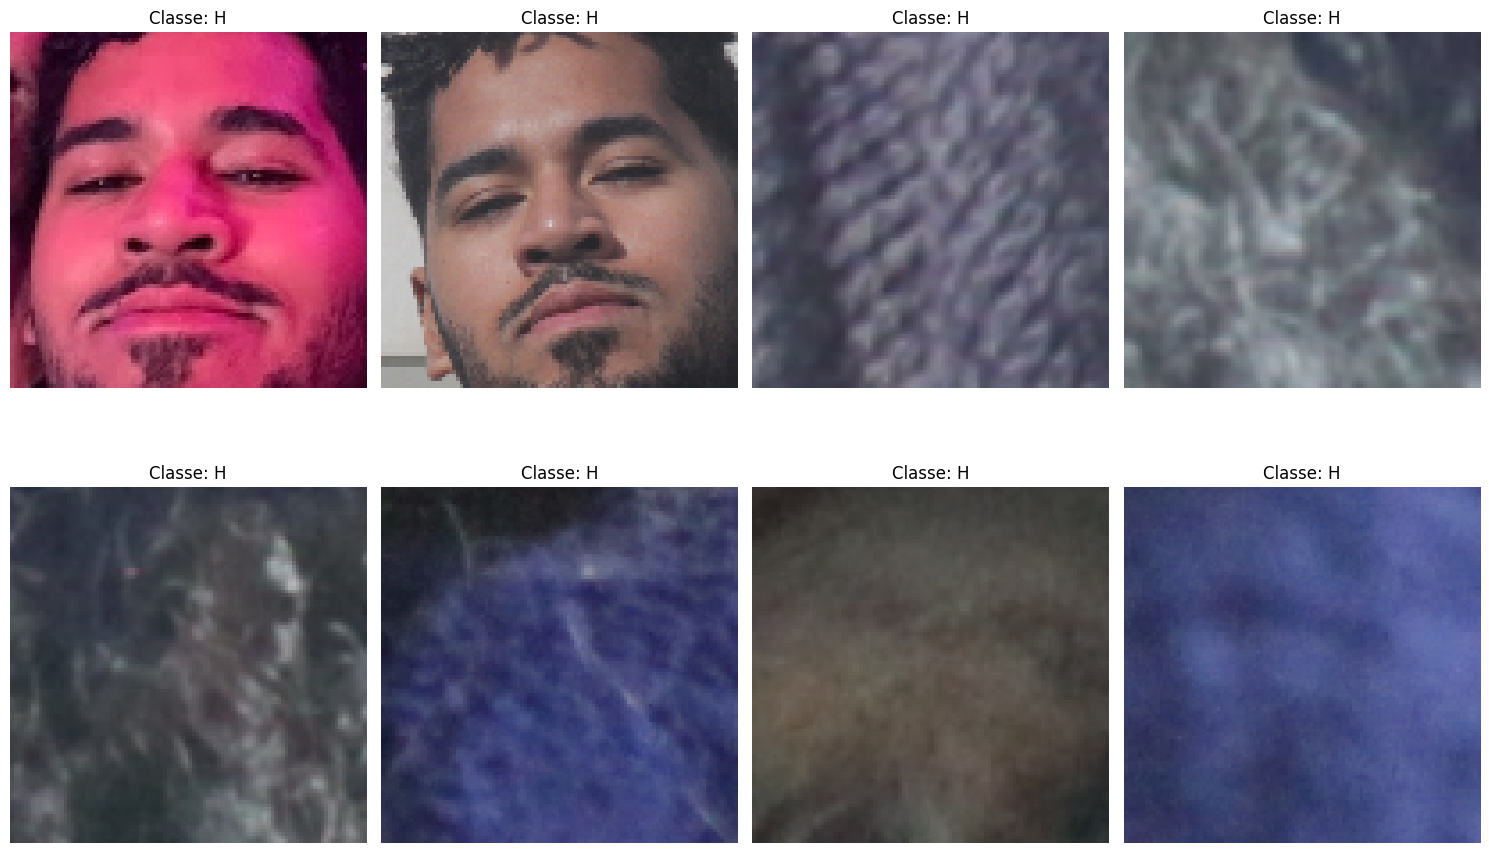


 BANCO DE DADOS CRIADO COM SUCESSO!

 Próximos passos:
1. O dataset está salvo em '/content/faces_dataset.pkl'
2. As faces extraídas estão em '/content/faces_dataset/'
3. Use este dataset para treinar seu classificador posteriormente

 Arquivos no dataset (/content/faces_dataset):
  - B_b (1)_0.jpg
  - H_h (1)_2.jpg
  - H_h (16)_0.jpg
  - B_b (2)_0.jpg
  - H_h (18)_3.jpg
  - B_b (8)_2.jpg
  - H_h (19)_0.jpg
  - H_h (18)_0.jpg
  - H_h (17)_1.jpg
  - H_h (6)_1.jpg
  ... e mais 23 arquivos


In [ ]:
# CÓDIGO COMPLEMENTAR - CRIAÇÃO DO BANCO DE DADOS
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle

# Definir caminhos das pastas (conforme seu ambiente)
H_PATH = "/content/h"  # Classe H
B_PATH = "/content/b"  # Classe B
DATASET_PATH = "/content/faces_dataset"  # Onde salvar as faces extraídas

# Criar diretório para as faces extraídas
!mkdir -p {DATASET_PATH}

print("Diretórios configurados com sucesso!")
print(f"Classe H: {H_PATH}")
print(f"Classe B: {B_PATH}")
print(f"Faces extraídas: {DATASET_PATH}")

# Verificar se as pastas existem
if not os.path.exists(H_PATH):
    print(f"ATENÇÃO: Pasta {H_PATH} não encontrada!")
    print("Por favor, faça upload das imagens da classe H para esta pasta")

if not os.path.exists(B_PATH):
    print(f"ATENÇÃO: Pasta {B_PATH} não encontrada!")
    print("Por favor, faça upload das imagens da classe B para esta pasta")

# Função para verificar e listar imagens nas pastas
def check_images_in_folder(folder_path, class_name):
    """Verifica e lista as imagens em uma pasta"""
    print(f"\n=== VERIFICANDO IMAGENS DA CLASSE {class_name} ===")

    if not os.path.exists(folder_path):
        print(f"Pasta {folder_path} não existe!")
        return []

    # Listar arquivos de imagem
    image_files = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_files.append(filename)

    print(f"Encontradas {len(image_files)} imagens em {folder_path}")
    for img in image_files:
        print(f"  - {img}")

    return image_files

# Verificar imagens disponíveis
h_images = check_images_in_folder(H_PATH, "H")
b_images = check_images_in_folder(B_PATH, "B")

# Função para detectar e extrair rostos das imagens
def extract_faces_from_folder(folder_path, class_label):
    """
    Extrai rostos das imagens de uma pasta específica
    """
    print(f"\n=== EXTRAINDO ROSTOS DA CLASSE {class_label} ===")

    faces_data = []
    labels = []
    extracted_count = 0

    if not os.path.exists(folder_path):
        print(f"Pasta {folder_path} não existe! Pulando...")
        return faces_data, labels

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Não foi possível ler a imagem: {filename}")
                continue

            # Converter para escala de cinza
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Detectar faces usando o mesmo Haar Cascade do seu código
            faces = face_cascade.detectMultiScale(
                gray,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30)
            )

            if len(faces) == 0:
                print(f"Nenhum rosto detectado em: {filename}")
                continue

            for i, (x, y, w, h) in enumerate(faces):
                # Extrair ROI (Region of Interest)
                face_roi = image[y:y+h, x:x+w]

                # Redimensionar para tamanho padrão
                face_resized = cv2.resize(face_roi, (100, 100))

                # Salvar face extraída
                face_filename = f"{class_label}_{filename.split('.')[0]}_{i}.jpg"
                face_path = os.path.join(DATASET_PATH, face_filename)
                cv2.imwrite(face_path, face_resized)

                # Adicionar aos dados de treinamento
                faces_data.append(face_resized)
                labels.append(class_label)

                extracted_count += 1
                print(f"✓ Rosto {i+1} extraído de {filename} -> {face_filename}")

    print(f"Total de rostos extraídos da classe {class_label}: {extracted_count}")
    return faces_data, labels

# Extrair rostos de ambas as classes
print("\n" + "="*50)
print("INICIANDO EXTRAÇÃO DE ROSTOS")
print("="*50)

all_faces_data = []
all_labels = []

# Extrair da classe H
h_faces, h_labels = extract_faces_from_folder(H_PATH, "H")
all_faces_data.extend(h_faces)
all_labels.extend(h_labels)

# Extrair da classe B
b_faces, b_labels = extract_faces_from_folder(B_PATH, "B")
all_faces_data.extend(b_faces)
all_labels.extend(b_labels)

print(f"\n=== RESUMO FINAL DO DATASET ===")
print(f"Total de rostos extraídos: {len(all_faces_data)}")
print(f"Rostos da classe H: {all_labels.count('H')}")
print(f"Rostos da classe B: {all_labels.count('B')}")

# Salvar o dataset em arquivo pickle para uso futuro
if all_faces_data:
    dataset = {
        'faces': all_faces_data,
        'labels': all_labels
    }

    with open('/content/faces_dataset.pkl', 'wb') as f:
        pickle.dump(dataset, f)

    print("\n Dataset salvo em '/content/faces_dataset.pkl'")

    # Função para visualizar algumas amostras do dataset
    def show_dataset_samples():
        """Mostra algumas amostras do dataset criado"""
        print("\n=== AMOSTRAS DO DATASET ===")

        plt.figure(figsize=(15, 10))

        # Mostrar até 8 amostras
        num_samples = min(8, len(all_faces_data))

        for i in range(num_samples):
            plt.subplot(2, 4, i+1)

            # Converter BGR para RGB para visualização correta
            img_rgb = cv2.cvtColor(all_faces_data[i], cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.title(f'Classe: {all_labels[i]}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Mostrar amostras
    show_dataset_samples()

    print("\n BANCO DE DADOS CRIADO COM SUCESSO!")
    print("\n Próximos passos:")
    print("1. O dataset está salvo em '/content/faces_dataset.pkl'")
    print("2. As faces extraídas estão em '/content/faces_dataset/'")
    print("3. Use este dataset para treinar seu classificador posteriormente")

else:
    print("❌ Nenhum rosto foi extraído. Verifique se:")
    print("   - As pastas /content/h e /content/b existem")
    print("   - Há imagens válidas nas pastas")
    print("   - As imagens contêm rostos detectáveis")

# Listar arquivos no dataset criado
print(f"\n Arquivos no dataset ({DATASET_PATH}):")
if os.path.exists(DATASET_PATH):
    dataset_files = os.listdir(DATASET_PATH)
    for file in dataset_files[:10]:  # Mostrar primeiros 10 arquivos
        print(f"  - {file}")
    if len(dataset_files) > 10:
        print(f"  ... e mais {len(dataset_files) - 10} arquivos")
else:
    print("Pasta do dataset não encontrada")

## Hope You Enjoyed!
If you enjoyed the tutorial and want to see more videos or tutorials check out my YouTube channel [HERE](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q?sub_confirmation=1)

Have a great day!